In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./..")

In [4]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
#
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm
#
from effcn.layers import FCCaps, FCCapsWOBias
from effcn.utils import count_parameters
from effcn.functions import margin_loss

In [5]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)

In [6]:
#!pip install einops

In [7]:
ds_train = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = True,                         
    transform = T.ToTensor(), 
    download = True,            
)
ds_test = datasets.MNIST(
    root = '/mnt/data/pytorch',
    train = False, 
    transform = T.ToTensor()
)
dl_train = DataLoader(ds_train, batch_size=2, shuffle=False)

In [8]:
transform_train = T.Compose([
    T.RandomRotation(degrees=(-30, 30)),
    T.RandomResizedCrop(
        28,
        scale=(0.8, 1.0),
        ratio=(1, 1),
    ),
    T.RandomAffine(
        degrees=(-30, 30),
        #translate=(0.1, 0.1)
    ),
    T.ToTensor()
])
transform_valid = T.Compose([
    T.ToTensor()
])

In [9]:
ds_train = datasets.MNIST(root='./../data', train=True, download=True, transform=transform_train)
ds_valid = datasets.MNIST(root="./../data", train=False, download=True, transform=transform_valid)
#
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=512, 
                                       shuffle=True, 
                                       num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, 
                                       batch_size=512, 
                                       shuffle=True, 
                                       num_workers=4)

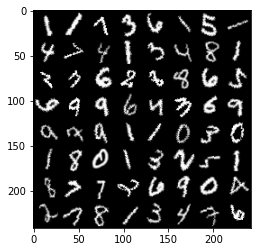

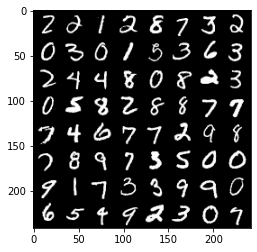

In [10]:
# plot train imgs
x, y = next(iter(dl_train))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

# plot valid imgs
x, y = next(iter(dl_valid))
img = torchvision.utils.make_grid(x[:64], nrow=8)
img = img.permute((1,2,0))
plt.imshow(img)
plt.show()

In [11]:
class VisualCapsules(nn.Module):
    def __init__(self, h, w, c, patch_dim, d=32, d_hidden=32):
        super().__init__()
        self.h = h   # img height
        self.w = w   # img width
        self.c = c   # img channels
        self.d = d   # embedding dim
        self.d_hidden = d_hidden   # hidden dimension
        self.patch_dim = patch_dim
        #
        self.n = h//patch_dim * w//patch_dim
        self.patch_size = patch_dim**2 * c
        
        # make sure it adds up
        assert self.n * patch_dim**2 == h * w

        self.pos_emb = nn.Parameter(torch.rand(1, self.n, d), requires_grad=True)
        self.f = nn.Sequential(
            nn.Linear(self.patch_size, self.d),
            #nn.ReLU(),
            #nn.Linear(d_hidden, self.d)
        )
    def forward(self, x):
        """
            in:  x (b, c, h, w)
            out: (b, patch_size, d)
        """
        batch_size = x.shape[0]
        img_patches = rearrange(
            x, 'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)
        img_patches = self.f(img_patches)
        img_patches = img_patches + self.pos_emb
        return img_patches

class MnistCaps(nn.Module):
    def __init__(self, patch_dim=7,d=32):
        super().__init__()
        self.patch_dim = patch_dim
        self.d = d

        self.visualcn = VisualCapsules(28, 28, 1, patch_dim, d)
        self.fccaps = FCCapsWOBias(self.visualcn.n, 10, d, d)
        
    def forward(self, x):
        x = self.visualcn(x)
        x = self.fccaps(x)
        return x

In [12]:
model = MnistCaps()
model = model.to(device)
print(count_parameters(model))

165952


In [13]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
num_epochs = 50
#
for epoch_idx in range(num_epochs):
    # ####################
    # TRAIN
    # ####################
    model.train()
    desc = "Train [{:3}/{:3}]:".format(epoch_idx, num_epochs)
    pbar = tqdm(dl_train, bar_format=desc + '{bar:10}{r_bar}{bar:-10b}')
    
    for x,y_true in pbar:
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        
        u_h = model.forward(x)
        
        # LOSS
        y_one_hot = F.one_hot(y_true, num_classes=10)
        loss = margin_loss(u_h, y_one_hot)

        loss.backward()
        
        optimizer.step()
        
        y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
        acc = (y_true == y_pred).sum() / y_true.shape[0]
        
        pbar.set_postfix(
                {'loss': loss.item(),
                 'acc': acc.item()
                 }
        )
    #
    # ####################
    # VALID
    # ####################
    if epoch_idx % 10 != 0:
        continue
    
    model.eval()
    
    total_correct = 0
    total = 0

    for x,y_true in dl_valid:
        x = x.to(device)
        y_true = y_true.to(device)
        
        with torch.no_grad():
            u_h = model.forward(x)
            
            y_pred = torch.argmax(torch.norm(u_h, dim=2), dim=1)
            total_correct += (y_true == y_pred).sum()
            total += y_true.shape[0]
    print("   acc_valid: {:.3f}".format(total_correct / total))

Train [  0/ 50]:██████████| 118/118 [00:03<00:00, 30.36it/s, loss=0.291, acc=0.635]                                                          


   acc_valid: 0.810


Train [  1/ 50]:██████████| 118/118 [00:03<00:00, 29.93it/s, loss=0.276, acc=0.646]                                                          
Train [  2/ 50]:██████████| 118/118 [00:04<00:00, 29.32it/s, loss=0.218, acc=0.75]                                                           
Train [  3/ 50]:██████████| 118/118 [00:04<00:00, 28.80it/s, loss=0.169, acc=0.823]                                                          
Train [  4/ 50]:██████████| 118/118 [00:03<00:00, 30.07it/s, loss=0.182, acc=0.802]                                                          
Train [  5/ 50]:██████████| 118/118 [00:03<00:00, 30.36it/s, loss=0.205, acc=0.792]                                                          
Train [  6/ 50]:██████████| 118/118 [00:04<00:00, 28.73it/s, loss=0.206, acc=0.74]                                                           
Train [  7/ 50]:██████████| 118/118 [00:04<00:00, 29.17it/s, loss=0.186, acc=0.792]                                                          
Train 

   acc_valid: 0.880


Train [ 11/ 50]:██████████| 118/118 [00:03<00:00, 30.24it/s, loss=0.203, acc=0.74]                                                           
Train [ 12/ 50]:██████████| 118/118 [00:03<00:00, 29.65it/s, loss=0.179, acc=0.792]                                                          
Train [ 13/ 50]:██████████| 118/118 [00:03<00:00, 29.64it/s, loss=0.185, acc=0.792]                                                          
Train [ 14/ 50]:██████████| 118/118 [00:03<00:00, 30.28it/s, loss=0.196, acc=0.74]                                                           
Train [ 15/ 50]:██████████| 118/118 [00:03<00:00, 29.83it/s, loss=0.172, acc=0.823]                                                          
Train [ 16/ 50]:██████████| 118/118 [00:03<00:00, 29.77it/s, loss=0.174, acc=0.823]                                                          
Train [ 17/ 50]:██████████| 118/118 [00:03<00:00, 30.13it/s, loss=0.154, acc=0.802]                                                          
Train 

   acc_valid: 0.902


Train [ 21/ 50]:██████████| 118/118 [00:03<00:00, 29.67it/s, loss=0.176, acc=0.771]                                                          
Train [ 22/ 50]:██████████| 118/118 [00:03<00:00, 29.72it/s, loss=0.184, acc=0.771]                                                          
Train [ 23/ 50]:██████████| 118/118 [00:03<00:00, 29.55it/s, loss=0.167, acc=0.833]                                                          
Train [ 24/ 50]:██████████| 118/118 [00:03<00:00, 29.56it/s, loss=0.111, acc=0.917]                                                          
Train [ 25/ 50]:██████████| 118/118 [00:03<00:00, 29.92it/s, loss=0.163, acc=0.812]                                                          
Train [ 26/ 50]:██████████| 118/118 [00:03<00:00, 30.00it/s, loss=0.139, acc=0.865]                                                          
Train [ 27/ 50]:██████████| 118/118 [00:04<00:00, 29.31it/s, loss=0.151, acc=0.823]                                                          
Train 

   acc_valid: 0.904


Train [ 31/ 50]:██████████| 118/118 [00:03<00:00, 30.26it/s, loss=0.132, acc=0.844]                                                          
Train [ 32/ 50]:██████████| 118/118 [00:03<00:00, 29.90it/s, loss=0.15, acc=0.844]                                                           
Train [ 33/ 50]:█▊        | 21/118 [00:00<00:03, 29.15it/s, loss=0.141, acc=0.848]                                                           